In [3]:
import time
from scipy import sparse
import scipy
import copy
from matplotlib import interactive
interactive(True)
from math import ceil
import pandas as pd
import numba as nb
import sys
eps = 0.08854187817 # F/A
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.linalg import lu,solve
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import plotly.express as px
import plotly.graph_objects as go
from vedo import *

In [1]:
def sphere_generator(N,D,Center):

  shpere_points = [[0,0,0] for _ in range(N)]
  phi = 0.5*(np.sqrt(5)-1)
  for i in range(N):
      n = i+1
      z = (2*n-1)/N-1
      x = np.sqrt(1 - z * z) * np.cos(2 * np.pi * n * phi)
      y = np.sqrt(1 - z * z) * np.sin(2 * np.pi * n * phi)
      shpere_points[i][0] = x*D + Center[0]
      shpere_points[i][1] = y*D + Center[1]
      shpere_points[i][2] = z*D + Center[2]
  return np.array(shpere_points)



In [4]:
box_size = np.array([100.0,100.0,100.0]).astype("float64")
(NX,NY,NZ) = (100,100,100)
(dx,dy,dz) = (box_size[0]/NX, box_size[1]/NY, box_size[2]/NZ)

# 在格子中内画个球, 球心(15.0, 15.0, 15.0), 半径 5.5
# 设置等势值
iso_level = 1
def sphere(crd):
     if crd[0] == 50.0 and crd[1] == 50.0 and crd[2] == 50.0 :
          return 1e10
     else:
          return 20.38/np.sqrt((crd[0]-50.0)**2 + (crd[1]-50.0)**2 + (crd[2]-50.0)**2)
field = np.zeros((NX+1,NY+1,NZ+1))
for i in range(NX+1):
     for j in range(NY+1):
          for k in range(NZ+1):
               field[i,j,k] = sphere(np.array([i*dx,j*dy,k*dz]))
               
# 给出切点的坐标，以及几何序号
cut_crd = measure.marching_cubes(field, iso_level,spacing=(dx, dy, dz))[0]
cut_cnt = cut_crd.shape[0]
cut_sgn = [int(i+(NX)*(NY)*(NZ)) for i in range(cut_cnt)]

# 给出需要计算的节点的全局序号
sgn_convert_to_calc = {}
# 全局序号的个数
sgn_calc_cnt = 0

now_sgn = 0
for k in range(NZ):
     for j in range(NY):
          for i in range(NX):
               sgn = i + j*NX + k*NX*NY
               if field[i,j,k] < iso_level:
                    sgn_convert_to_calc[sgn] = now_sgn
                    now_sgn += 1
for i in range(cut_cnt):
     sgn_convert_to_calc[cut_sgn[i]] = now_sgn
     now_sgn += 1
     
calc_convert_to_sgn = {v: k for k, v in sgn_convert_to_calc.items()}
sgn_calc_cnt = len(sgn_convert_to_calc)
first_cut_sgn = sgn_calc_cnt-cut_cnt

In [239]:
new_phi = np.loadtxt( r"C:/Users/15653/Desktop/FGM-Python-Debug/CSR-Matrix/result.txt")
#new_phi = Phi
phi_hexa_mesh = np.ones((NX)*(NY)*(NZ))
for i in range(first_cut_sgn):
    phi_hexa_mesh[calc_convert_to_sgn[i]] = new_phi[i]
space_phi = np.zeros((NX+1,NY+1,NZ+1))
for i in range(NX+1):
    for j in range(NY+1):
        for k in range(NZ+1):
            space_phi[i,j,k] = phi_hexa_mesh[int(i%NX + j%NY*NX+k%NZ*NX*NY)]
np.savetxt(r"./Phi_result_iso_readmode.txt",phi_hexa_mesh)

In [6]:
# Generate convex Faces of shpere
N_sphere = 500
R_sphere = 1
charge_crd = np.array([0 ,0, 0])
boundary_atom_center = np.array([50,50,50])
points = sphere_generator(N_sphere, R_sphere, charge_crd)
hull  = scipy.spatial.ConvexHull(points,3)
face = hull.simplices
temp_edges = []
for i in range(face.shape[0]):
    vertex = np.sort(face[i])
    temp_edges.append(str(vertex[0]) + "+" + str(vertex[1]))
    temp_edges.append(str(vertex[0]) + "+" + str(vertex[2]))
    temp_edges.append(str(vertex[1]) + "+" + str(vertex[2]))
edges = np.array([np.array(i.split("+")).astype(np.int64) for i in list(set(temp_edges))])
edge_length_init = np.linalg.norm(points[edges[:,0]] - points[edges[:,1]],axis=1)

for i in range(face.shape[0]):
        a = points[face[i,0]]
        b = points[face[i,1]]
        c = points[face[i,2]]
        normal = np.cross(b-a,c-a)
        vec_to_center  = charge_crd - (a+b+c)/3
        if np.dot(normal,vec_to_center) > 0:
            d = face[i,1]
            face[i,1] = face[i,2]
            face[i,2] = d

In [240]:
shpere_points = np.loadtxt("unit_500Sphere/result.txt")

In [8]:
shpere_points[0]

array([74.5767, 49.6081, 41.0181])

In [9]:
def which_hexa(crd):
    i = (crd[0]//dx)%NX
    j = (crd[1]//dy)%NY
    k = (crd[2]//dz)%NZ
    return int(i + j*NX + k*NX*NY)



for i in range(500):
    if phi_hexa_mesh[which_hexa(shpere_points[i])] == 1.0:
        print(i)

In [88]:
def get_Potential_and_field(crd,Phi_hexa,NX,NY,NZ,dx,dy,dz):
    i = (crd[0]//dx)%NX
    j = (crd[1]//dy)%NY
    k = (crd[2]//dz)%NZ
    x = (crd[0]%dx)/dx
    y= (crd[1]%dy)/dy
    z = (crd[2]%dz)/dz
    Phi1 = Phi_hexa[int(i + j*NX + k*NX*NY)]
    Phi2 = Phi_hexa[int((i+1)%NX + j*NX + k*NX*NY)]
    Phi3 = Phi_hexa[int((i+1)%NX + (j+1)%NY*NX + k*NX*NY)]
    Phi4 = Phi_hexa[int(i + (j+1)%NY*NX + k*NX*NY)]
    Phi5 = Phi_hexa[int(i + j*NX + (k+1)%NZ*NX*NY)]
    Phi6 = Phi_hexa[int((i+1)%NX + j*NX + (k+1)%NZ*NX*NY)]
    Phi7 = Phi_hexa[int((i+1)%NX + (j+1)%NY*NX + (k+1)%NZ*NX*NY)]
    Phi8 = Phi_hexa[int(i + (j+1)%NY*NX + (k+1)%NZ*NX*NY)]
    Phi = (1-x)*(1-y)*(1-z)*Phi1 + x*(1-y)*(1-z)*Phi2 + x*y*(1-z)*Phi3 + (1-x)*y*(1-z)*Phi4 + (1-x)*(1-y)*z*Phi5 + x*(1-y)*z*Phi6 + x*y*z*Phi7 + (1-x)*y*z*Phi8
    Ex = -np.array(
        [
            -Phi1* (1 - y) *(1 - z) + Phi2* (1 - y)* (1 - z) + Phi3 *y *(1 - z) -  Phi4* y* (1 - z) - Phi5* (1 - y)* z + Phi6 *(1 - y) *z + Phi7 *y *z - Phi8* y* z,
            -Phi1 *(1 - x) *(1 - z) + Phi4* (1 - x)* (1 - z) - Phi2 *x *(1 - z) + Phi3* x* (1 - z) - Phi5* (1 - x) *z + Phi8 *(1 - x) *z - Phi6 *x *z + Phi7* x* z,
            -Phi1 *(1 - x) *(1 - y) + Phi5 *(1 - x)* (1 - y) - Phi2* x *(1 - y) + Phi6* x *(1 - y) - Phi4 *(1 - x)* y + Phi8 *(1 - x)* y - Phi3* x *y + Phi7* x* y
        ]
    )
    return (Phi,Ex)

def green_force(charge_crd, Phi_hexa, shpere_crd, face):
    E_sum = 0
    Num = []
    for i in range(face.shape[0]):
        a = shpere_crd[face[i,0]]
        b = shpere_crd[face[i,1]]
        c = shpere_crd[face[i,2]]
        (a_Phi, a_E) =  get_Potential_and_field(a,Phi_hexa,NX,NY,NZ,dx,dy,dz)
        (b_Phi, b_E) =  get_Potential_and_field(b,Phi_hexa,NX,NY,NZ,dx,dy,dz)
        (c_Phi, c_E) =  get_Potential_and_field(c,Phi_hexa,NX,NY,NZ,dx,dy,dz)
        print(a_Phi,b_Phi,c_Phi)
        normal = np.cross(b-a,c-a)
        S_triangle = 0.5*np.linalg.norm(normal)
        n_triangle = normal/np.linalg.norm(normal)
        E = (a_E + b_E + c_E)/3
        Phi = (a_Phi + b_Phi + c_Phi)/3
        vec_r =  (a+b+c)/3- charge_crd
        r = np.linalg.norm(vec_r)
        E_sum += 1/r**3 * Phi *  n_triangle * S_triangle
        E_sum += 1/r**3 * (np.dot(n_triangle,E) - 3*Phi/r**2 * vec_r.dot(n_triangle)) * vec_r * S_triangle
    return -E_sum

In [241]:
# Debug 验证Cuda-电场力算的对不对
Sphere_E = np.loadtxt(r"C:\\Users\\15653\\Desktop\\FGM-CUDA-Clean\\GreenForce-Clean\\GreenForce-Clean\\sphere_Electric_Field_each_point.txt")
Sphere_Phi = np.loadtxt(r"C:\\Users\\15653\\Desktop\\FGM-CUDA-Clean\\GreenForce-Clean\\GreenForce-Clean\\sphere_Phi_each_point.txt")

In [230]:
def green_force_using_CUDA_result(charge_crd, shpere_crd, face, Sphere_E, Sphere_Phi):
    E_sum = 0
    for fc in range(face.shape[0]):
        a = shpere_crd[face[fc,0]]
        b = shpere_crd[face[fc,1]]
        c = shpere_crd[face[fc,2]]
        (a_Phi, a_E) = (Sphere_Phi[face[fc,0]], Sphere_E[face[fc,0]])
        (b_Phi, b_E) = (Sphere_Phi[face[fc,1]], Sphere_E[face[fc,1]])
        (c_Phi, c_E) = (Sphere_Phi[face[fc,2]], Sphere_E[face[fc,2]])
        normal = np.cross(b-a,c-a)
        S_triangle = 0.5*np.linalg.norm(normal)
        n_triangle = normal/np.linalg.norm(normal)
        E = (a_E + b_E + c_E)/3
        Phi = (a_Phi + b_Phi + c_Phi)/3
        vec_r =  (a+b+c)/3- charge_crd
        r = np.linalg.norm(vec_r)

        E_sum += 1/r**3 * Phi *  n_triangle * S_triangle
        E_sum += 1/r**3 * (np.dot(n_triangle,E) - 3*Phi/r**2 * vec_r.dot(n_triangle)) * vec_r * S_triangle
    return -E_sum

In [232]:
def green_force_using_CUDA_result(charge_crd, shpere_crd, face, Sphere_E, Sphere_Phi):
    E_result = [0,0,0]
    for fc in range(face.shape[0]):
        a = shpere_crd[face[fc,0]]
        b = shpere_crd[face[fc,1]]
        c = shpere_crd[face[fc,2]]
        (x1,y1,z1) = (a[0],a[1],a[2])
        (x2,y2,z2) = (b[0],b[1],b[2])
        (x3,y3,z3) = (c[0],c[1],c[2])
        (a_Phi, a_E) = (Sphere_Phi[face[fc,0]], Sphere_E[face[fc,0]])
        (b_Phi, b_E) = (Sphere_Phi[face[fc,1]], Sphere_E[face[fc,1]])
        (c_Phi, c_E) = (Sphere_Phi[face[fc,2]], Sphere_E[face[fc,2]])


        nx =  (y2 - y1) * (z3 - z1) - (z2 - z1) * (y3 - y1)
        ny =  (z2 - z1) * (x3 - x1) - (x2 - x1) * (z3 - z1)
        nz =  (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)
        S =  0.5 * sqrt(nx * nx + ny * ny + nz * nz)
        (nx, ny, nz) = (nx/(2*S), ny/(2*S), nz/(2*S))
        (Ex, Ey, Ez) = (a_E + b_E + c_E)/3
        Phi = (a_Phi + b_Phi + c_Phi)/3
        (vec_x, vec_y, vec_z) =  (a+b+c)/3- charge_crd
        r = sqrt(vec_x * vec_x + vec_y * vec_y + vec_z * vec_z)

        E_result[0] += 1/r**3 *Phi*S*nx
        E_result[1] += 1/r**3 *Phi*S*ny
        E_result[2] += 1/r**3 *Phi*S*nz
        cNT = 1/r**3 *S* (Ex*nx + Ey*ny + Ez*nz  -3*Phi/r**2 *(vec_x*nx + vec_y*ny + vec_z*nz))
        E_result[0] += cNT * vec_x
        E_result[1] += cNT * vec_y
        E_result[2] += cNT * vec_z
    return -np.array(E_result)

In [242]:
green_force_using_CUDA_result(np.array([75.,50.,50.]), shpere_points, face, Sphere_E, Sphere_Phi)

array([ 0.1308961 ,  0.02050731, -0.00240276])

In [98]:
green_force(np.array([75.,50.,50.]), phi_hexa_mesh, shpere_points, face)

1.2094854057898703 1.1339653575207578 1.1080672449579447
1.0407799075973998 1.0535498067923088 1.0548965392833576
1.0407799075973998 1.0548965392833576 1.0377136125391988
1.0407799075973998 1.0377136125391988 1.0310670554087877
1.0830304353057023 1.0548965392833576 1.0535498067923088
1.0830304353057023 1.1080672449579447 1.1339653575207578
1.0284995323525772 1.0310670554087877 1.0377136125391988
1.057415772319204 1.05813699351381 1.058123084836713
1.02388849727479 1.0242913958384814 1.0242351486342285
1.0242672095393517 1.025935061792044 1.0245695458942206
1.0242672095393517 1.0290384174674554 1.025935061792044
1.0240035820524245 1.0290384174674554 1.0242672095393517
1.024468436993132 1.0245695458942206 1.025935061792044
1.0339455639721842 1.025935061792044 1.0290384174674554
1.03532634573002 1.0296893375817917 1.0251594801450818
1.0306505666396213 1.0266673970900004 1.0250586786740543
1.028553484077933 1.0270177404798306 1.0248079233343192
1.0350853851984139 1.0468731462349696 1.03104

array([ 0.12509303,  0.02214341, -0.00294564])

In [55]:
fig = go.Figure(data=go.Cone(x=shpere_points[:,0], y=shpere_points[:,1], z=shpere_points[:,2], u=Sphere_Phi[:], v=Sphere_Phi[:], w=Sphere_Phi[:],))
#fig.add_trace(go.Scatter3d(
#        x=Err[:,0], 
#        y=Err[:,1], 
#        z=Err[:,2],
#    ))
fig.show()

In [56]:
E_Phi = np.zeros((500))
for i in range(500):
    E_Phi[i] = get_Potential_and_field(shpere_points[i],phi_hexa_mesh,NX,NY,NZ,dx,dy,dz)[0]

Err = np.array([[83.7797, 51.0115, 51.7149],[83.8513 ,48.9261 ,51.225 ],[83.9783, 50.4036 ,50.3293]])
fig = go.Figure(data=go.Cone(x=shpere_points[:,0], y=shpere_points[:,1], z=shpere_points[:,2], u=E_Phi[:], v=E_Phi[:], w=E_Phi[:],))
#fig.add_trace(go.Scatter3d(
#        x=Err[:,0], 
#        y=Err[:,1], 
#        z=Err[:,2],
#    ))
fig.show()

In [54]:
fig = go.Figure(data=go.Cone(x=shpere_points[:,0], y=shpere_points[:,1], z=shpere_points[:,2], u=Sphere_E[:,0], v=Sphere_E[:,1], w=Sphere_E[:,2],))
#fig.add_trace(go.Scatter3d(
#        x=Err[:,0], 
#        y=Err[:,1], 
#        z=Err[:,2],
#    ))
fig.show()

In [17]:
E_shpere = np.zeros((500,3))
for i in range(500):
    E_shpere[i] = get_Potential_and_field(shpere_points[i],phi_hexa_mesh,NX,NY,NZ,dx,dy,dz)[-1]

Err = np.array([[83.7797, 51.0115, 51.7149],[83.8513 ,48.9261 ,51.225 ],[83.9783, 50.4036 ,50.3293]])
fig = go.Figure(data=go.Cone(x=shpere_points[:,0], y=shpere_points[:,1], z=shpere_points[:,2], u=E_shpere[:,0], v=E_shpere[:,1], w=E_shpere[:,2],))
#fig.add_trace(go.Scatter3d(
#        x=Err[:,0], 
#        y=Err[:,1], 
#        z=Err[:,2],
#    ))
fig.show()

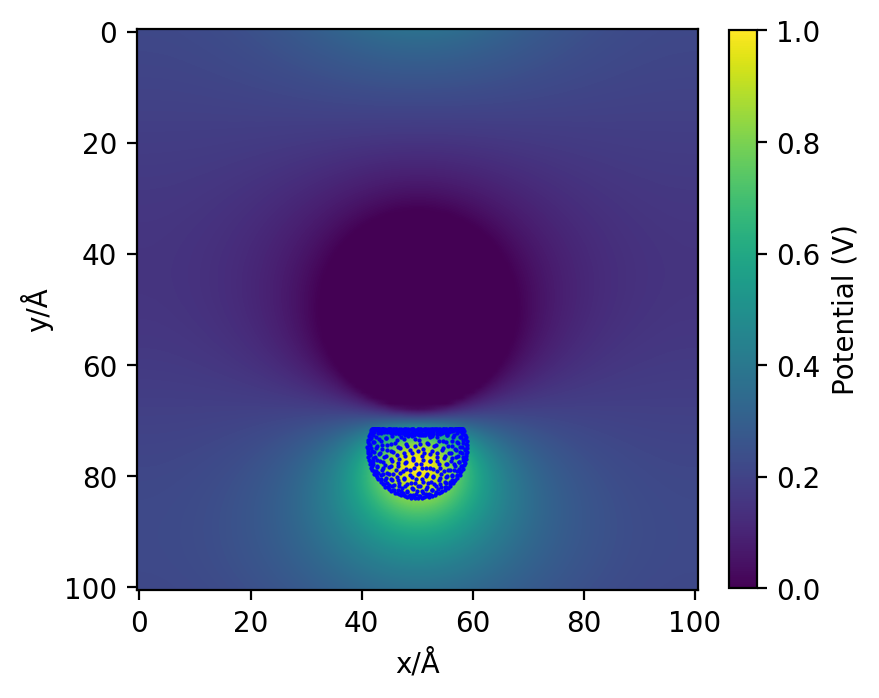

In [238]:
M = space_phi[:,:,40]
fig = plt.figure(figsize=(4,4), dpi=200)
plt.xlabel('x/Å')
plt.ylabel('y/Å')
plt.imshow(M,interpolation="bilinear")
plt.scatter(shpere_points[:,1],shpere_points[:,0],c="blue",s=0.3)
plt.colorbar(fraction=0.045,label="Potential (V)")
plt.show()